## Behavioral Cloning
This project helps to drive the car on its own by studying Human Behavior. The data is recorded from the simulator and then the model is trained with respective images and their steering angles. I used the dataset provided by Udacity.  I did record images myself but when I train it with mine, there was a minor error by car going little out of track .The dataset contains JPG images of dimensions 160x320x3.


In [3]:
# Import libraries
import csv
import tensorflow as tf
from keras.models import Sequential, model_from_json, load_model
from keras.optimizers import *
from keras.layers import Dense, Activation, Flatten, Dropout, Lambda, Cropping2D,MaxPooling2D, ELU
from keras.layers.convolutional import Convolution2D
from scipy.misc import imread, imsave
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random



## Data Preprocessing

- I have added a small angle 0.25 to the left camera and subtract a small angle of 0.25 from the right camera. This is done to bring back the car to the center if it wanders off to the sides.

- Flipping the images horizontally is done to overcome the bias created during the training because the car turns to the left during most of the track and the images need to be flipped horizontally to simulate right turning and reverse steering angle.

- Data is augmented and generated using python generators. So for every epoch, the optimizer practically sees a new and augmented data set.


In [4]:
def flip(image, measurement):
    return np.fliplr(image), -measurement

def get_images(i, data):
    #Storing camera postions and corrections done to car to come to the center of the track
    camera_pos, corrections = ['left', 'center', 'right'], [.25, 0, -.25]
    identifier, rand = data.index[i], random.choice([0, 1, 2])

    #Correcting the measurements
    measurement = data['steering'][identifier] + corrections[rand]

    path = PATH + data[camera_pos[rand]][identifier][1:]
    if rand == 1: path = PATH + data[camera_pos[rand]][identifier]
    image = imread(path)

    if random.random() > 0.5:
        image, measurement = flip(image, measurement)

  
    return image, measurement


def generate(data, batch_size):
    while True:
        
        data.sample(frac = 1)

        for start in range(0, len(data), batch_size):
            images, measurements = [], []
            
  #Adding data in terms of batches using generators and appending both images and measurement array
            for indexes in range(start, start + batch_size):
                if indexes < len(data):
                    image, measurement = get_images(indexes, data)
                    measurements.append(measurement)
                    images.append(image)

        yield np.array(images), np.array(measurements)
    
    


## Data Exploration

- The sample data images are taken from Udacity data and are shown in the below code snippet.
- Description of the data is given with steering angle histogram is plotted.
- Sample augmented image (taken from random row) is displayed as well which lowers the brightness of the image and colour channel change.


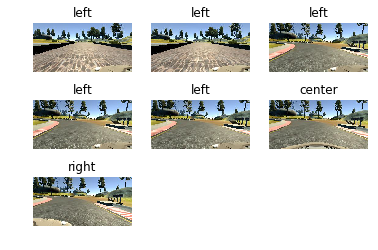

In [8]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
PATH = "C:/Users/harsh/Desktop/data/data/"
CSV_FILE="driving_log.csv"
from keras.preprocessing.image import img_to_array, load_img
DATA = pd.read_csv(PATH + CSV_FILE, usecols=[0,1,2,3])
i = 0


for i in range(0,5):
    for camera in ['left', 'center', 'right']:
        image = load_img(PATH +DATA.iloc[i][camera].strip())
        image = img_to_array(image).astype(np.uint8)
        plt.subplot(3, 3, i+1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(camera)
        i += 1
        
    
 




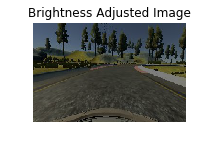

In [37]:
row = DATA.iloc[2500]
steering = row['steering']
image1 = load_img(PATH +row["center"].strip())
image1 = img_to_array(image1).astype(np.uint8)
plt.subplot(2,2,1)
image1 = cv2.cvtColor(image1,cv2.COLOR_RGB2HSV)
random_bright = .25+np.random.uniform()
image1[:,:,2] = image1[:,:,2]*random_bright
image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
plt.imshow(image1, aspect='auto')
plt.axis('off')
plt.title("Brightness Adjusted Image")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001984B8AF518>]], dtype=object)

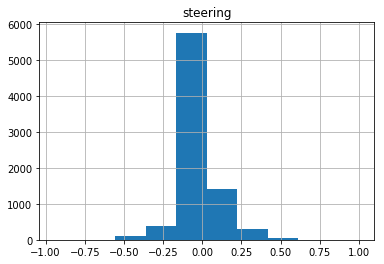

In [26]:
DATA.describe(include='all')

DATA.hist(column='steering')

## Model Architecture

- I noticed that the hood of the car is visible in the lower portion of the image and unwanted trees and skies in the image can be removed.
- I have cropped 70 pixels from top and 25 from below to fasten processing of GPU.
- Data is normalized by using Lambda method as mentioned in the classroom.
- The model is same as NVIDIA Paper but with MaxPooling layer after each convolution layer.
- The model summary is given by model.summary() function.


In [3]:
learning_rate = 0.0001
activation_relu = 'relu'


model = Sequential()

model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape = (160, 320, 3)))
model.add(Cropping2D(cropping=((70,25),(0,0)),input_shape=(160,320,3)))

model.add(Convolution2D(24, 5, 5, border_mode='same', subsample=(2, 2)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Convolution2D(36, 5, 5, border_mode='same', subsample=(2, 2)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Convolution2D(48, 5, 5, border_mode='same', subsample=(2, 2)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Flatten())


model.add(Dense(1164))
model.add(Activation(activation_relu))

model.add(Dense(100))
model.add(Activation(activation_relu))

model.add(Dense(50))
model.add(Activation(activation_relu))

model.add(Dense(10))
model.add(Activation(activation_relu))

model.add(Dense(1))

model.summary()

#Adam optimizer is used with mean squared error
model.compile(optimizer=Adam(learning_rate), loss="mse" )





____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 65, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 33, 160, 24)   1824        cropping2d_1[0][0]               
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 33, 160, 24)   0           convolution2d_1[0][0]            
___________________________________________________________________________________________

## Training Process
- Batch size of both training_generator and validation_generator was 64. The training data and validation data are split in 85:15 ratio as per data available. 
- I used Adam optimizer with 1e-4 learning rate. 
- Finally, when it comes to the number of training epochs I tried several possibilities such as 5, 8, 10, 25 and 50. However, 10 works well on both training and validation tracks. 
- The fit generator generates additional data from the preprocessing techniques used in above functions namely generate and get_images function.
- The data used for training is by Udacity Dataset

In [ ]:
BATCH_SIZE = 64
no_of_epochs = 10
PATH = "C:/Users/harsh/Desktop/data/data/"
CSV_FILE = "driving_log.csv"

DATA = pd.read_csv(PATH + CSV_FILE, usecols = [0, 1, 2, 3])

#Split the data into 85 and 15%.
train, valid = train_test_split(DATA, test_size = 0.15)
total_train= len(train)
total_valid = len(valid)

#################################################################
print('Training model...')

training_generator = generate(train, batch_size = BATCH_SIZE)
validation_generator = generate(valid, batch_size = BATCH_SIZE)



history_object = model.fit_generator(training_generator,
                 samples_per_epoch =total_train,
                 validation_data = validation_generator,
                 nb_val_samples = total_valid,
                 nb_epoch = no_of_epochs)

#################################################################
print('Saving model...')

model.save("model2.h5")

with open("model2.json", "w") as json_file:
  json_file.write(model.to_json())

print("Model Saved.")

Training model...
Epoch 1/10
6808/6830 [============================>.] - ETA: 4s - loss: 0.0177 

C:\Users\harsh\Anaconda3\envs\carnd-term1\lib\site-packages\keras\engine\training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


6854/6830 [==============================] - 1509s - loss: 0.0176 - val_loss: 0.0258
Epoch 2/10
6854/6830 [==============================] - 1451s - loss: 9.8087e-04 - val_loss: 0.0295
Epoch 3/10
6854/6830 [==============================] - 1457s - loss: 1.6993e-05 - val_loss: 0.0297
Epoch 4/10
6854/6830 [==============================] - 1444s - loss: 4.9548e-07 - val_loss: 0.0292
Epoch 5/10
6854/6830 [==============================] - 1429s - loss: 3.8164e-08 - val_loss: 0.0292
Epoch 6/10
6854/6830 [==============================] - 1443s - loss: 3.3298e-07 - val_loss: 0.0291
Epoch 7/10
6854/6830 [==============================] - 1451s - loss: 1.4868e-04 - val_loss: 0.0277
Epoch 8/10
6854/6830 [==============================] - 1447s - loss: 3.5705e-04 - val_loss: 0.0284
Epoch 9/10
6854/6830 [==============================] - 7087s - loss: 1.5179e-06 - val_loss: 0.0294
Epoch 10/10
6808/6830 [============================>.] - ETA: 6s - loss: 8.8639e-09 

Warning message might be because the number of training data does not divide the batch every iteration.

## Future Directions
When it comes to extensions and future directions, I would like to highlight followings.

- Train a model with own collected data
- Experiment with other possible data augmentation techniques.
- Increase the training data to avoid overfitting.